In [3]:
import numpy as np
import matplotlib
# matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import bernoulli
from scipy.stats import pareto
import networkx as nx
import matplotlib.pyplot as plt
import random
import scipy.io
import collections
import pickle
from mpl_toolkits.axes_grid1.inset_locator import (inset_axes,InsetPosition,mark_inset)
import copy

In [ ]:
#Generates a power-law graph with a given number of nodes (N) and a power-law exponent (alpha)
def Powerlaw_Graph(N, alpha):
    No_of_Nodes = N  # Number of nodes in each of the power-law graphs

    alpha = alpha # Power-law exponent

    # Generating degree sequence by sampling from continuous power-distribution and,
    #  then rounding to the nearest integer.
    deg_sequence = pareto.rvs(alpha - 1, loc=0, scale=1, size=No_of_Nodes)
    deg_sequence = np.round(deg_sequence, decimals=0)

    # Ensuring the sum of the sampled degrees even
    # (to be valid sequence of degrees the sum should be even since it is equal to twice the number of edges)
    if (np.sum(deg_sequence) % 2) != 0:
        deg_sequence[0] = deg_sequence[0] + 1
    deg_sequence = deg_sequence.astype(int)

    # Generating a network G with the degree sequence generated previously by using the configuration model
    G = nx.configuration_model(list(deg_sequence))

    # Removing parallel edges
    G=nx.Graph(G) 

    # Removing self-loops
    G.remove_edges_from(G.selfloop_edges())
    
    return(G)

In [ ]:
#Function to change the degree-sharing correlation to a specified value
def Attribute_Swapping(A, s, p_ks_specified, Max_Iter = 1e5):
    G = nx.from_numpy_matrix(A)
    nodes, degrees = zip(*G.degree())
    degrees = np.array(degrees)
    degrees = [float(d) for d in degrees]

    #Correlation between degrees and sharing
    p_ks = np.corrcoef(degrees, s)[0,1]
    
    count = 0
    while np.abs(p_ks - p_ks_specified) > 0.02 and count <= Max_Iter:
        if p_ks >= p_ks_specified:
            while p_ks >= p_ks_specified and count <= Max_Iter:
                count = count + 1
                nodes_1 = list(np.where(s==1)[0])
                nodes_0 = list(np.where(s==0)[0])

                node_1 = random.choice(nodes_1)
                node_0 = random.choice(nodes_0)

                if G.degree(node_1) > G.degree(node_0):
                    s_new = s
                    s_new[node_0] = 1
                    s_new[node_1] = 0
                    s = s_new
                    p_ks = np.corrcoef(degrees, s)[0,1]


        if p_ks <= p_ks_specified:
            while p_ks <= p_ks_specified and count <= Max_Iter:
                count = count + 1
                nodes_1 = list(np.where(s==1)[0])
                nodes_0 = list(np.where(s==0)[0])

                node_1 = random.choice(nodes_1)
                node_0 = random.choice(nodes_0)

                if G.degree(node_1) < G.degree(node_0):
                    s_new = s
                    s_new[node_0] = 1
                    s_new[node_1] = 0
                    s = s_new
                    p_ks = np.corrcoef(degrees, s)[0,1]

    return (s)

In [ ]:
#Function to change the assortativity coefficient to a specified value
def Edge_Rewiring(A_input, r_kk_specified, Max_Iter = 1e5):
    
    A = copy.deepcopy(A_input) 
    
    G = nx.from_numpy_matrix(A)
    nodes, degrees = zip(*G.degree())
    degrees = np.array(degrees)
    degrees = [float(d) for d in degrees]

    #Assortativity Coefficient
    r_kk = nx.degree_assortativity_coefficient(G)
    
    count = 0
    while np.abs(r_kk - r_kk_specified) > 0.02 and count <= Max_Iter:
        if r_kk >= r_kk_specified:
            while r_kk >= r_kk_specified and count <= Max_Iter:
                count = count + 1
                
                # Sample two unique edges (without repetition)
                [(v1, w1), (v2,w2)] = random.sample(G.edges, 2)
                
                #If the intended new edges do not exist, check the assortativity and modify the graph according to Lemma 1 of Eur. Phys. J. B 76, 643–652 (2010) by Mieghem et al.
                degrees_sorted = sorted([(v1, G.degree[v1]),(w1, G.degree[w1]),(v2, G.degree[v2]), (w2,G.degree[w2])], key=lambda x: x[1], reverse = True)

                A_new = copy.deepcopy(A)
                A_new[v1,w1] = 0; A_new[w1,v1] = 0
                A_new[v2,w2] = 0; A_new[w2,v2] = 0
                if A[degrees_sorted[0][0],degrees_sorted[3][0]] == 0 and A[degrees_sorted[1][0],degrees_sorted[2][0]] == 0:
                    A_new[degrees_sorted[0][0],degrees_sorted[3][0]] = 1; A_new[degrees_sorted[3][0],degrees_sorted[0][0]] = 1
                    A_new[degrees_sorted[1][0],degrees_sorted[2][0]] = 1; A_new[degrees_sorted[2][0],degrees_sorted[1][0]] = 1
                    G_new = nx.from_numpy_matrix(A_new); #Generating the new graph G_new from A_new
                    r_kk_new = nx.degree_assortativity_coefficient(G_new)
                        
                    if r_kk_new < r_kk:
                        G = G_new
                        A = A_new
                        r_kk = r_kk_new 
                        print(r'count = ' + str(count))                        
                        print(r'r_{kk} = ' + str(r_kk))
                        print('')                                                

                
        elif r_kk <= r_kk_specified:
            while r_kk <= r_kk_specified and count <= Max_Iter:
                count = count + 1
                
                # Sample two unique edges (without repetition)
                [(v1, w1), (v2,w2)] = random.sample(G.edges, 2)
                
                #If the intended new edges do not exist, check the assortativity and modify the graph according to Lemma 1 of Eur. Phys. J. B 76, 643–652 (2010) by Mieghem et al.
                degrees_sorted = sorted([(v1, G.degree[v1]),(w1, G.degree[w1]),(v2, G.degree[v2]), (w2,G.degree[w2])], key=lambda x: x[1], reverse = True)

                A_new = copy.deepcopy(A)
                A_new[v1,w1] = 0; A_new[w1,v1] = 0
                A_new[v2,w2] = 0; A_new[w2,v2] = 0
                if A[degrees_sorted[0][0],degrees_sorted[1][0]] == 0 and A[degrees_sorted[2][0],degrees_sorted[3][0]] == 0: 
                    A_new[degrees_sorted[0][0],degrees_sorted[1][0]] = 1; A_new[degrees_sorted[1][0],degrees_sorted[0][0]] = 1
                    A_new[degrees_sorted[2][0],degrees_sorted[3][0]] = 1; A_new[degrees_sorted[3][0],degrees_sorted[2][0]] = 1
                    G_new = nx.from_numpy_matrix(A_new); #Generating the new graph G_new from A_new
                    r_kk_new = nx.degree_assortativity_coefficient(G_new)
                        
                    if r_kk_new > r_kk:
                        G = G_new
                        A = A_new
                        r_kk = r_kk_new
                        print(r'count = ' + str(count))                        
                        print(r'r_{kk} = ' + str(r_kk))
                        print('')            
            
    return(A)

In [ ]:
## Function for evaluting the mean absolute error for difference sample sizes
def MeanAbsError(G, p_share, p_ks_specified, n_list, No_iterations = 100):
    #Dictionary for storing the results for various n values
    Dict_Results = {}
    
    #Obtaining the adjacency matrix of the graph G"
    A = nx.to_numpy_array(G, dtype=int)

    #Average degree of the graph G = (V,E)
    d = [val for (node, val) in G.degree()]
    bar_d = sum(d)/len(d)
    
    # Deciding whether a node shared a piece of information as iid Bernoulli random variables
    s = np.array([bernoulli.rvs(p_share, size=1) for v in G.nodes])
    s = s.flatten()
    
    #Varying the degree-attribute correlation
    s = Attribute_Swapping(A, s, p_ks_specified, Max_Iter = 1e6)

    # The function f which indicates whether each node is exposed to the piece of information or not
    f = [int(v>0) for v in np.matmul(A,s).flatten().tolist()]

    #True parameter
    bar_f = sum(f)/len(f)   

    # The following for-loop considers four different values of the sample size
    for n in n_list:

        #Vectors to store the estimates from the two methods
        Estimate_X_vec_error = []
        Estimate_Y_vec_error = []
        Estimate_Z_vec_error = []

        i = 0
        # The following while loop generates vanilla and friendship paradox based MLEs in each iteration        
        while i < No_iterations: 

            # Sampling n Random Nodes (X_1, X_2,....X_n) independently from the set of nodes of the network G
            X_nodes = list(np.random.choice(G.nodes, size=n))

            # Sampling n Random Friends (Y_1, Y_2,....Y_n) independently (version-1 of friendship paradox)
            # by listing all friends and then sampling the resulting list uniformly
            Y_nodes = list(np.random.choice(np.array(list(G.edges(data=False))).flatten(), size=n))
            
            # Sampling n Random Friends (Z_1, Z_2,....Z_n) independently (version-2 of friendship paradox)
            X1_nodes = list(np.random.choice(G.nodes, size=10))
            Z_nodes = [np.random.choice([v for v in list(G[x])]) for x in X1_nodes]

            # The degrees (d(X_1), d(X_2),....d(X_n)) of the n random nodes
            #  and the degrees (d(Y_1), d(Y_2),....d(Y_n)) of n random friends are stored as lists X and Y respectively
            dX = [G.degree(x) for x in X_nodes]
            dY = [G.degree(y) for y in Y_nodes]
            dZ = [G.degree(z) for z in Z_nodes]            

            # Computing the vanilla estimate
            f_hat_vanilla = sum([f[v] for v in X_nodes])/n
            Estimate_X_vec_error.append(np.abs(f_hat_vanilla - bar_f)*100/bar_f)

            # Computing the friendship paradox based method
            f_hat_FP1 = sum([(bar_d * f[v]/G.degree(v)) for v in Y_nodes])/n
            Estimate_Y_vec_error.append(np.abs(f_hat_FP1 - bar_f)*100/bar_f)
            
            # Computing the friendship paradox (v2) based method
            f_hat_FP2 = sum([(bar_d * f[v]/G.degree(v)) for v in Z_nodes])/n
            Estimate_Z_vec_error.append(np.abs(f_hat_FP2 - bar_f)*100/bar_f)            
 
            i = i + 1

        #Storing the values in a dictionary in compact form
        Dict_Results[n] = (n, bar_f, np.corrcoef(d, s)[0,1], np.mean(Estimate_X_vec_error), np.mean(Estimate_Y_vec_error), np.mean(Estimate_Z_vec_error))
        
    return Dict_Results

# Simulation based Study

## Generating the 10000 node graphs with alpha = 2.5 and various assortativity coefficients

In [ ]:
N = 10000
alpha = 2.5

G = Powerlaw_Graph(N, alpha)
A_10k_original_alpha2pt5 = nx.to_numpy_matrix(G); # returns a <class 'numpy.matrix'> type object
print(nx.degree_assortativity_coefficient(G))

In [ ]:
r_kk = -0.2
A_10k_alpha2pt5_rkk_neg0pt2 = Edge_Rewiring(A_10k_alpha2pt5_rkk_neg0pt2, r_kk)

np.save("A_10k_alpha2pt5_rkk_neg0pt2.npy", A_10k_alpha2pt5_rkk_neg0pt2)

In [ ]:
r_kk = 0.0
A_10k_alpha2pt5_rkk_0 = Edge_Rewiring(A_10k_original_alpha2pt5, r_kk)

np.save("A_10k_alpha2pt5_rkk_0.npy", A_10k_alpha2pt5_rkk_0)

In [ ]:
r_kk = 0.2
A_10k_alpha2pt5_rkk_0pt2 = Edge_Rewiring(A_10k_alpha2pt5_rkk_0pt2, r_kk, Max_Iter = 3e5)

np.save("A_10k_alpha2pt5_rkk_0pt2.npy", A_10k_alpha2pt5_rkk_0pt2)

## Simulating the two methods on graphs with alpha = 2.5 and various assortativity coefficients

In [ ]:
#Generating the results and saving

Graph_Names = ['A_10k_alpha2pt5_rkk_neg0pt2.npy', 'A_10k_alpha2pt5_rkk_0.npy', 'A_10k_alpha2pt5_rkk_0pt2.npy']

for j in np.arange(0,len(Graph_Names)):
    A = np.load(Graph_Names[j]) 
    G = nx.from_numpy_matrix(A)

    n_list = [10, 20, 30, 40, 50]
    
    i=0
    for p_ks_specified in [-0.2, 0, 0.2]:
        k=0
        for p_share in [0.005, 0.015, 0.025]:
            
            Dict_Name = 'Results_Numerical/' + Graph_Names[j] + 'p_ks_specified' + str(p_ks_specified) + 'p_share' + str(p_share)
            Dict_Results = MeanAbsError(G, p_share, p_ks_specified, n_list, No_iterations = 5000)            
            
            try:
                import cPickle as pickle
            except ImportError:  
                import pickle
            with open(Dict_Name, 'wb') as fp:
               pickle.dump(Dict_Results, fp, protocol=pickle.HIGHEST_PROTOCOL)
            
            
            (n, bar_f, p_ks, Vanilla_error, FP_error_1, FP_error_2) = zip(*list(Dict_Results.values()))            
            print('Graph = ' + Graph_Names[j])
            print('p_share = ' + str(p_share))
            print('p_ks (specified)= ' + str(p_ks_specified))                        
            print('p_ks (actual)= ' + str(p_ks[0]))    
            print('bar{f} = ' + str(bar_f[0]))                
            print('')                
            
            k+=1
        i+=1

Graph = A_10k_alpha2pt5_rkk_neg0pt2.npy
p_share = 0.005
p_ks (specified)= -0.2
p_ks (actual)= -0.01588142827071363
bar{f} = 0.0038

Graph = A_10k_alpha2pt5_rkk_neg0pt2.npy
p_share = 0.015
p_ks (specified)= -0.2
p_ks (actual)= -0.027452415746611898
bar{f} = 0.0056

Graph = A_10k_alpha2pt5_rkk_neg0pt2.npy
p_share = 0.025
p_ks (specified)= -0.2
p_ks (actual)= -0.036016727086500507
bar{f} = 0.0071

Graph = A_10k_alpha2pt5_rkk_neg0pt2.npy
p_share = 0.005
p_ks (specified)= 0
p_ks (actual)= -0.0026119216255195443
bar{f} = 0.013

Graph = A_10k_alpha2pt5_rkk_neg0pt2.npy
p_share = 0.015
p_ks (specified)= 0
p_ks (actual)= 0.005819796902813517
bar{f} = 0.0437

Graph = A_10k_alpha2pt5_rkk_neg0pt2.npy
p_share = 0.025
p_ks (specified)= 0
p_ks (actual)= 0.00653103720844869
bar{f} = 0.073

Graph = A_10k_alpha2pt5_rkk_neg0pt2.npy
p_share = 0.005
p_ks (specified)= 0.2
p_ks (actual)= 0.20534466076703992
bar{f} = 0.1291

Graph = A_10k_alpha2pt5_rkk_neg0pt2.npy
p_share = 0.015
p_ks (specified)= 0.2
p_ks (ac

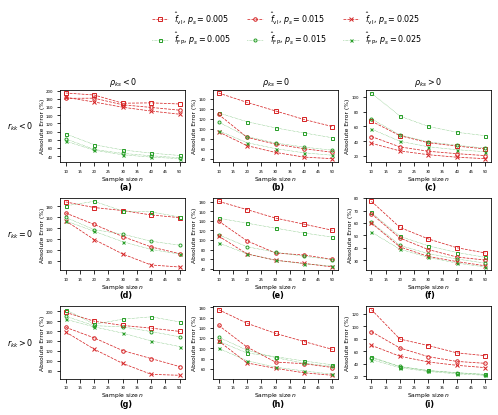

In [3]:
#Loading the results and creating plots

%matplotlib inline
import matplotlib.pylab as pl

Graph_Names = ['A_10k_alpha2pt5_rkk_neg0pt2.npy', 'A_10k_alpha2pt5_rkk_0.npy', 'A_10k_alpha2pt5_rkk_0pt2.npy']
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(7.02, 4.75))

matplotlib.rc('xtick', labelsize=4) 
matplotlib.rc('ytick', labelsize=4) 

MARKERS = ['s','o','x']

for j in np.arange(0,len(Graph_Names)):
    A = np.load(Graph_Names[j]) 
    G = nx.from_numpy_matrix(A)

    n_list = [10, 20, 30, 40, 50]
    
    i=0
    for p_ks_specified in [-0.2, 0, 0.2]:
        k=0
        for p_share in [0.005, 0.015, 0.025]:
            
            Dict_Name = 'Results_Numerical/' + Graph_Names[j] + 'p_ks_specified' + str(p_ks_specified) + 'p_share' + str(p_share)
            try:
                import cPickle as pickle
            except ImportError:  
                import pickle
            with open(Dict_Name, 'rb') as fp:
                Dict_Results = pickle.load(fp)            
            
            (n, bar_f, p_ks, Vanilla_error, FP_error_1, FP_error_2) = zip(*list(Dict_Results.values()))
            ax[j][i].plot(n, Vanilla_error, # For percentage error
#             ax[j][i].plot(n, [i * bar_f[0]/100 for i in Vanilla_error], #For absolute error                          
                          label = r'$\hat{f}_{\mathrm{vl}}$,' + r' $p_s = $' + str(p_share),
                          color = 'tab:red', 
                          marker = MARKERS[k],
                          markersize = 3.5,  
                          markerfacecolor = 'none',                          
                          linestyle = '--',
                          linewidth = 0.75                      
                         )
                          
            ax[j][i].plot(n, FP_error_1, # For percentage error
#             ax[j][i].plot(n, [i * bar_f[0]/100 for i in FP_error_1], #For absolute error                            
                          label = r'$\hat{f}_{\mathrm{FP}}$,' + ' $p_s = $' + str(p_share),
                          color = 'tab:green',
                          marker = MARKERS[k],  
                          markersize = 3,      
                          markerfacecolor = 'none',                        
                          linestyle = ':' ,                         
                          linewidth = 0.5
                         )             
            
            handles, labels = ax[j][i].get_legend_handles_labels()
            
            print('Graph = ' + Graph_Names[j])
            print('p_share = ' + str(p_share))
            print('p_ks (specified)= ' + str(p_ks_specified))                        
            print('p_ks (actual)= ' + str(p_ks[0]))    
            print('bar{f} = ' + str(bar_f[0]))                
            print('')                
            
            k+=1
        i+=1

# Setting the x and y labels    
for AX in ax.flat:
    AX.set_xlabel(r'Sample size $n$', fontsize=6, labelpad=1)
    AX.set_ylabel(r'Absolute Error (%)', fontsize=6, labelpad=1)
    AX.xaxis.set_tick_params(labelsize=4)
    AX.yaxis.set_tick_params(labelsize=4)    
#     AX.tick_params(axis='y', labelpad=0)

# Setting the row and column headers    
cols = [r'$\rho_{ks} < 0$', r'$\rho_{ks} = 0$', r'$\rho_{ks} > 0 $']
rows = [r'$r_{kk} < 0$', r'$r_{kk} = 0$', r'$r_{kk} > 0$']    
pad = 5 
for AX, col in zip(ax[0], cols):
    AX.annotate(col, xy=(0.5, 1.0), xytext=(0, pad+1),
                xycoords='axes fraction', textcoords='offset points',
                size=8, ha='center', va='baseline')

for AX, row in zip(ax[:,0], rows):
    AX.annotate(row, xy=(0, 0.5), xytext=(-AX.yaxis.labelpad - pad, 0),
                xycoords=AX.yaxis.label, textcoords='offset points',
                size=8, ha='right', va='center')
fig.tight_layout()    

# Adding panel numbers
panel_list = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)', '(i)']
panel_list_ind = 0
for AX in ax.flat:
    AX.text(0.47, -0.28, panel_list[panel_list_ind], transform=AX.transAxes, fontsize=8, fontweight='bold', va='top')
    panel_list_ind = panel_list_ind + 1

# Setting the legend and adjusting plots
fig.legend(handles, labels, loc='center', ncol=3, fontsize=8, bbox_to_anchor=(0.575, +1.105), edgecolor = 'none')        
plt.subplots_adjust(bottom = 0.08, wspace=0.22, hspace=0.5)    
plt.savefig('Figures/AbsError_Alpha2pt5_v2_percent.pdf', bbox_inches='tight')    


## Simulating the two methods on graphs with alpha = 2.2 and various assortativity coefficients

In [ ]:
#Generating the results and saving

Graph_Names = ['A_10k_alpha2pt2_rkk_neg0pt2.npy', 'A_10k_alpha2pt2_rkk_0.npy']

for j in np.arange(0,len(Graph_Names)):
    A = np.load(Graph_Names[j]) 
    G = nx.from_numpy_matrix(A)

    n_list = [10, 20, 30, 40, 50]
    
    i=0
    for p_ks_specified in [-0.2, 0, 0.2]:
        k=0
        for p_share in [0.005, 0.015, 0.025]:
            
            Dict_Name = 'Results_Numerical/' + Graph_Names[j] + 'p_ks_specified' + str(p_ks_specified) + 'p_share' + str(p_share)
            Dict_Results = MeanAbsError(G, p_share, p_ks_specified, n_list, No_iterations = 5000)            
            
            try:
                import cPickle as pickle
            except ImportError:  
                import pickle
            with open(Dict_Name, 'wb') as fp:
               pickle.dump(Dict_Results, fp, protocol=pickle.HIGHEST_PROTOCOL)
            
            
            (n, bar_f, p_ks, Vanilla_error, FP_error_1, FP_error_2) = zip(*list(Dict_Results.values()))            
            print('Graph = ' + Graph_Names[j])
            print('p_share = ' + str(p_share))
            print('p_ks (specified)= ' + str(p_ks_specified))                        
            print('p_ks (actual)= ' + str(p_ks[0]))    
            print('bar{f} = ' + str(bar_f[0]))                
            print('')                
            
            k+=1
        i+=1

Graph = A_10k_alpha2pt2_rkk_neg0pt2.npy
p_share = 0.005
p_ks (specified)= -0.2
p_ks (actual)= -0.013869952164581045
$\bar{f} = $0.0029

Graph = A_10k_alpha2pt2_rkk_neg0pt2.npy
p_share = 0.015
p_ks (specified)= -0.2
p_ks (actual)= -0.02397540616103468
$\bar{f} = $0.008

Graph = A_10k_alpha2pt2_rkk_neg0pt2.npy
p_share = 0.025
p_ks (specified)= -0.2
p_ks (actual)= -0.032229858345252556
$\bar{f} = $0.0115

Graph = A_10k_alpha2pt2_rkk_neg0pt2.npy
p_share = 0.005
p_ks (specified)= 0
p_ks (actual)= 0.005069757490872751
$\bar{f} = $0.0276

Graph = A_10k_alpha2pt2_rkk_neg0pt2.npy
p_share = 0.015
p_ks (specified)= 0
p_ks (actual)= -0.008522349571558252
$\bar{f} = $0.0395

Graph = A_10k_alpha2pt2_rkk_neg0pt2.npy
p_share = 0.025
p_ks (specified)= 0
p_ks (actual)= 0.00575316124322013
$\bar{f} = $0.1064

Graph = A_10k_alpha2pt2_rkk_neg0pt2.npy
p_share = 0.005
p_ks (specified)= 0.2
p_ks (actual)= 0.20108773011973777
$\bar{f} = $0.23

Graph = A_10k_alpha2pt2_rkk_neg0pt2.npy
p_share = 0.015
p_ks (speci

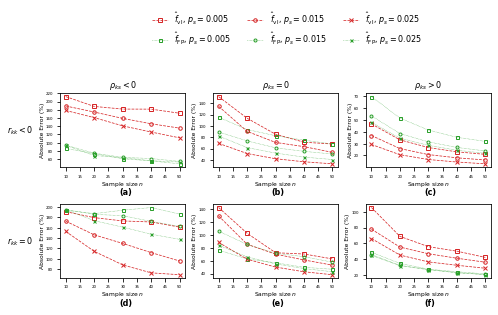

In [4]:
#Loading the results and creating plots

%matplotlib inline
import matplotlib.pylab as pl

Graph_Names = ['A_10k_alpha2pt2_rkk_neg0pt2.npy', 'A_10k_alpha2pt2_rkk_0.npy']
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(7.02, 3.18))

matplotlib.rc('xtick', labelsize=4) 
matplotlib.rc('ytick', labelsize=4) 

MARKERS = ['s','o','x']

for j in np.arange(0,len(Graph_Names)):
    A = np.load(Graph_Names[j]) 
    G = nx.from_numpy_matrix(A)

    n_list = [10, 20, 30, 40, 50]
    
    i=0
    for p_ks_specified in [-0.2, 0, 0.2]:
        k=0
        for p_share in [0.005, 0.015, 0.025]:

            Dict_Name = 'Results_Numerical/' + Graph_Names[j] + 'p_ks_specified' + str(p_ks_specified) + 'p_share' + str(p_share)
            try:
                import cPickle as pickle
            except ImportError:  
                import pickle
            with open(Dict_Name, 'rb') as fp:
                Dict_Results = pickle.load(fp)            
              
            (n, bar_f, p_ks, Vanilla_error, FP_error_1, FP_error_2) = zip(*list(Dict_Results.values()))
            ax[j][i].plot(n, Vanilla_error, # For percentage error
#             ax[j][i].plot(n, [i * bar_f[0]/100 for i in Vanilla_error], #For absolute error                          
                          label = r'$\hat{f}_{\mathrm{vl}}$,' + r' $p_s = $' + str(p_share),
                          color = 'tab:red', 
                          marker = MARKERS[k],
                          markersize = 3.5,  
                          markerfacecolor = 'none',                          
                          linestyle = '--',
                          linewidth = 0.75                      
                         )
                          
            ax[j][i].plot(n, FP_error_1, # For percentage error
#             ax[j][i].plot(n, [i * bar_f[0]/100 for i in FP_error_1], #For absolute error                            
                          label = r'$\hat{f}_{\mathrm{FP}}$,' + ' $p_s = $' + str(p_share),
                          color = 'tab:green',
                          marker = MARKERS[k],  
                          markersize = 3,      
                          markerfacecolor = 'none',                        
                          linestyle = ':' ,                         
                          linewidth = 0.5
                         )             
            
            handles, labels = ax[j][i].get_legend_handles_labels()
            
            print('Graph = ' + Graph_Names[j])
            print('p_share = ' + str(p_share))
            print('p_ks (specified)= ' + str(p_ks_specified))                        
            print('p_ks (actual)= ' + str(p_ks[0]))    
            print(r'$\bar{f} = $' + str(bar_f[0]))    
            print('')                
            
            k+=1
        i+=1

# Setting the x and y labels    
for AX in ax.flat:
    AX.set_xlabel(r'Sample size $n$', fontsize=6, labelpad=1)
    AX.set_ylabel(r'Absolute Error (%)', fontsize=6, labelpad=1)
    AX.xaxis.set_tick_params(labelsize=4)
    AX.yaxis.set_tick_params(labelsize=4)      
#     AX.tick_params(axis='y', labelpad=0)

# Setting the row and column headers    
cols = [r'$\rho_{ks} < 0$', r'$\rho_{ks} = 0$', r'$\rho_{ks} > 0 $']
rows = [r'$r_{kk} < 0$', r'$r_{kk} = 0$']    
pad = 5 
for AX, col in zip(ax[0], cols):
    AX.annotate(col, xy=(0.5, 1.0), xytext=(0, pad+1),
                xycoords='axes fraction', textcoords='offset points',
                size=8, ha='center', va='baseline')

for AX, row in zip(ax[:,0], rows):
    AX.annotate(row, xy=(0, 0.5), xytext=(-AX.yaxis.labelpad - pad, 0),
                xycoords=AX.yaxis.label, textcoords='offset points',
                size=8, ha='right', va='center')
fig.tight_layout()    

# Adding panel numbers
panel_list = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)']
panel_list_ind = 0
for AX in ax.flat:
    AX.text(0.47, -0.28, panel_list[panel_list_ind], transform=AX.transAxes, fontsize=8, fontweight='bold', va='top')
    panel_list_ind = panel_list_ind + 1

# Setting the legend and adjusting plots
fig.legend(handles, labels, loc='center', ncol=3, fontsize=8, bbox_to_anchor=(0.575, +1.17), edgecolor = 'none')        
plt.subplots_adjust(bottom = 0.08, wspace=0.22, hspace=0.5)    
plt.savefig('Figures/AbsError_Alpha2pt2_v2_percent.pdf', bbox_inches='tight')    


# Empirical Study on Real-World Networks

In [ ]:
## Generating the results and saving
def SaveError(G, GraphName):

    n_list = [int(np.ceil(x*len(G.nodes()))) for x in [0.001, 0.002, 0.003, 0.004, 0.005]]

    i=0
    for p_ks_specified in [-0.2, 0, 0.2]:
        k=0
        for p_share in [0.001, 0.0025, 0.005]:
            
            
            Dict_Name = 'Results_Empirical/' + GraphName + 'p_ks_specified' + str(p_ks_specified) + 'p_share' + str(p_share)
            Dict_Results = MeanAbsError(G, p_share, p_ks_specified, n_list, No_iterations = 5000)            
            
            try:
                import cPickle as pickle
            except ImportError:  
                import pickle
            with open(Dict_Name, 'wb') as fp:
               pickle.dump(Dict_Results, fp, protocol=pickle.HIGHEST_PROTOCOL)
            
            (n, bar_f, p_ks, Vanilla_error, FP_error_1, FP_error_2) = zip(*list(Dict_Results.values()))               
            print(GraphName + r'$r_{kk}$ = ' + str(nx.degree_assortativity_coefficient(G)))
            print('p_share = ' + str(p_share))
            print('p_ks (specified)= ' + str(p_ks_specified))                        
            print('p_ks (actual)= ' + str(p_ks[0]))    
            print(r'$\bar{f} = $' + str(bar_f[0]))                
            print('')                

            k+=1
        i+=1

In [6]:
## Loading the results and plotting
def PlotError(GraphName, FigName):
    %matplotlib inline
    import matplotlib.pylab as pl
    
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(7.02, 1.5))

    matplotlib.rc('xtick', labelsize=4) 
    matplotlib.rc('ytick', labelsize=4) 

    MARKERS = ['s','o','x']

    n_list = [int(np.ceil(x*len(G.nodes()))) for x in [0.001, 0.002, 0.003, 0.004, 0.005]]

    i=0
    for p_ks_specified in [-0.2, 0, 0.2]:
        k=0
        for p_share in [0.001, 0.0025, 0.005]:

            Dict_Name = 'Results_Empirical/' + GraphName + 'p_ks_specified' + str(p_ks_specified) + 'p_share' + str(p_share)
            try:
                import cPickle as pickle
            except ImportError:  
                import pickle
            with open(Dict_Name, 'rb') as fp:
                Dict_Results = pickle.load(fp)            
                
            (n, bar_f, p_ks, Vanilla_error, FP_error_1, FP_error_2) = zip(*list(Dict_Results.values()))
            ax[i].plot(n, Vanilla_error, #For percentage error
#             ax[i].plot(n, [i * bar_f[0]/100 for i in Vanilla_error], #For absolute error                                                      
                          label = r'$\hat{f}_{\mathrm{vl}}$' + r', $p_s = $' + str(p_share),
                          color = 'tab:red', 
                          marker = MARKERS[k],
                          markersize = 3.5,  
                          markerfacecolor = 'none',                          
                          linestyle = '--',
                          linewidth = 0.75                      
                         )

            ax[i].plot(n, FP_error_1, #For percentage error
#             ax[i].plot(n, [i * bar_f[0]/100 for i in FP_error_1], #For absolute error                               
                          label = r'$\hat{f}_{\mathrm{FP}}$' + ', $p_s = $' + str(p_share),
                          color = 'tab:green',
                          marker = MARKERS[k],  
                          markersize = 3,      
                          markerfacecolor = 'none',                        
                          linestyle = ':' ,                         
                          linewidth = 0.5
                         )             

            handles, labels = ax[i].get_legend_handles_labels()

            print(GraphName + r'$r_{kk}$ = ' + str(nx.degree_assortativity_coefficient(G)))
            print('p_share = ' + str(p_share))
            print('p_ks (specified)= ' + str(p_ks_specified))                        
            print('p_ks (actual)= ' + str(p_ks[0]))    
            print(r'$\bar{f} = $' + str(bar_f[0]))                
            print('')                

            k+=1
        i+=1

    # Setting the x and y labels    
    for AX in ax.flat:
        AX.set_xlabel(r'Sample size $n$', fontsize=6, labelpad=1)
        AX.set_ylabel(r'Absolute Error (%)', fontsize=6, labelpad=1)
        AX.xaxis.set_tick_params(labelsize=4)
        AX.yaxis.set_tick_params(labelsize=4)     
    #     AX.tick_params(axis='y', labelpad=0)

    # Setting the row and column headers    
    cols = [r'$\rho_{ks} < 0$', r'$\rho_{ks} = 0$', r'$\rho_{ks} > 0 $']
    pad = 5 
    for AX, col in zip(ax, cols):
        AX.annotate(col, xy=(0.5, 1.0), xytext=(0, pad+1),
                    xycoords='axes fraction', textcoords='offset points',
                    size=8, ha='center', va='baseline')

    fig.tight_layout()    

    # Adding panel numbers
    panel_list = ['(a)', '(b)', '(c)']
    panel_list_ind = 0
    for AX in ax.flat:
        AX.text(0.47, -0.28, panel_list[panel_list_ind], transform=AX.transAxes, fontsize=8, fontweight='bold', va='top')
        panel_list_ind = panel_list_ind + 1

    # Setting the legend and adjusting plots
    fig.legend(handles, labels, loc='center', ncol=3, fontsize=8, bbox_to_anchor=(0.51, +1.51), edgecolor = 'none')        
    plt.subplots_adjust(bottom = 0.08, wspace=0.22, hspace=0.5)    
    plt.savefig('Figures/' + FigName, bbox_inches='tight')

## Simulating the two methods on a AstroPh Coauthorship Dataset

In [ ]:
#Generating the graph from the data
G = nx.Graph()
edges = nx.read_edgelist("CA_AstroPh.txt")
G.add_edges_from(edges.edges)
A = nx.to_numpy_matrix(G); # returns a <class 'numpy.matrix'> type object
#nx.draw(G, with_labels=False, font_weight='bold')

#Converting the <type 'numpy.ndarray'> object first to a <type
#'numpy.ndarray'> and then to a matlab matrix.
A = np.array(A); #Converting the <type 'numpy.ndarray'> object first to a <type 'numpy.ndarray'>
G = nx.from_numpy_matrix(A); #Generating the graph G from A

In [ ]:
print(r'r_{kk} = ' + str(nx.degree_assortativity_coefficient(G)))
print(r'Number of nodes = ' + str(len(G.nodes())))
print(r'Average Degree = ' + str(np.mean(list(dict(G.degree()).values()))))

nx.draw(G, node_size = 1)

In [ ]:
SaveError(G, 'CA_AstroPh.txt')

CA_AstroPh.txt$r_{kk}$ = -0.0134834281077109
p_share = 0.001
p_ks (specified)= -0.2
p_ks (actual)= -0.019209761141881773
$\bar{f} = $0.0008523332623055614

CA_AstroPh.txt$r_{kk}$ = -0.0134834281077109
p_share = 0.0025
p_ks (specified)= -0.2
p_ks (actual)= -0.034328328060734575
$\bar{f} = $0.0026635414447048794

CA_AstroPh.txt$r_{kk}$ = -0.0134834281077109
p_share = 0.005
p_ks (specified)= -0.2
p_ks (actual)= -0.0481323056772934
$\bar{f} = $0.005220541231621564

CA_AstroPh.txt$r_{kk}$ = -0.0134834281077109
p_share = 0.001
p_ks (specified)= 0
p_ks (actual)= 0.0023299695167328257
$\bar{f} = $0.015821436181546984

CA_AstroPh.txt$r_{kk}$ = -0.0134834281077109
p_share = 0.0025
p_ks (specified)= 0
p_ks (actual)= 0.015033228203546984
$\bar{f} = $0.06142126571489452

CA_AstroPh.txt$r_{kk}$ = -0.0134834281077109
p_share = 0.005
p_ks (specified)= 0
p_ks (actual)= -0.00200988976103198
$\bar{f} = $0.08017259748561688

CA_AstroPh.txt$r_{kk}$ = -0.0134834281077109
p_share = 0.001
p_ks (specified)= 0.

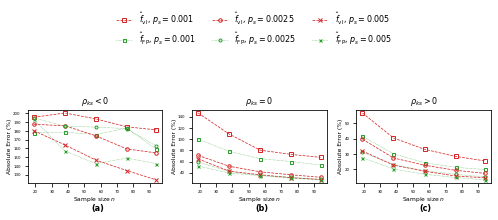

In [7]:
PlotError('CA_AstroPh.txt', 'AbsError_CA_AstroPh_v2_percent.pdf')

## Simulating the two methods on a GrQc Coauthorship Dataset

In [ ]:
#Generating the graph from the data
G = nx.Graph()
edges = nx.read_edgelist("CA_GrQc.txt")
G.add_edges_from(edges.edges)
A = nx.to_numpy_matrix(G); # returns a <class 'numpy.matrix'> type object
#nx.draw(G, with_labels=False, font_weight='bold')

#Converting the <type 'numpy.ndarray'> object first to a <type
#'numpy.ndarray'> and then to a matlab matrix.
A = np.array(A); #Converting the <type 'numpy.ndarray'> object first to a <type 'numpy.ndarray'>
G = nx.from_numpy_matrix(A); #Generating the graph G from A

In [ ]:
print(r'r_{kk} = ' + str(nx.degree_assortativity_coefficient(G)))
print(r'Number of nodes = ' + str(len(G.nodes())))
print(r'Average Degree = ' + str(np.mean(list(dict(G.degree()).values()))))

nx.draw(G, node_size = 1)

In [ ]:
SaveError(G, 'CA_GrQc.txt')

CA_GrQc.txt$r_{kk}$ = -0.0134834281077109
p_share = 0.001
p_ks (specified)= -0.2
p_ks (actual)= -0.019368882594584417
$\bar{f} = $0.0011446012972148034

CA_GrQc.txt$r_{kk}$ = -0.0134834281077109
p_share = 0.0025
p_ks (specified)= -0.2
p_ks (actual)= -0.022369531823705362
$\bar{f} = $0.0015261350629530714

CA_GrQc.txt$r_{kk}$ = -0.0134834281077109
p_share = 0.005
p_ks (specified)= -0.2
p_ks (actual)= -0.04413153878421964
$\bar{f} = $0.005913773368943152

CA_GrQc.txt$r_{kk}$ = -0.0134834281077109
p_share = 0.001
p_ks (specified)= 0
p_ks (actual)= -0.002020511132665943
$\bar{f} = $0.010873712323540634

CA_GrQc.txt$r_{kk}$ = -0.0134834281077109
p_share = 0.0025
p_ks (specified)= 0
p_ks (actual)= -0.0067949340928576095
$\bar{f} = $0.008202975963372758

CA_GrQc.txt$r_{kk}$ = -0.0134834281077109
p_share = 0.005
p_ks (specified)= 0
p_ks (actual)= 0.0028861719134015747
$\bar{f} = $0.02060282334986646

CA_GrQc.txt$r_{kk}$ = -0.0134834281077109
p_share = 0.001
p_ks (specified)= 0.2
p_ks (actual)=

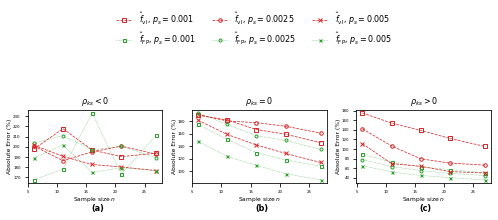

In [8]:
PlotError('CA_GrQc.txt', 'AbsError_CA_GrQc_v2_percent.pdf')

## Simulating the two methods on a Athlete Dataset

In [ ]:
#Generating the graph from the data
G = nx.read_gpickle("athletes_edges.gpickle")
A = nx.to_numpy_matrix(G)
A = np.array(A);
G = nx.from_numpy_matrix(A);

In [ ]:
print(r'r_{kk} = ' + str(nx.degree_assortativity_coefficient(G)))
print(r'Number of nodes = ' + str(len(G.nodes())))
print(r'Average Degree = ' + str(np.mean(list(dict(G.degree()).values()))))

nx.draw(G, node_size = 1)

In [ ]:
SaveError(G, 'athletes_edges.gpickle')

athletes_edges.gpickle$r_{kk}$ = -0.0134834281077109
p_share = 0.001
p_ks (specified)= -0.2
p_ks (actual)= -0.019599638892591552
$\bar{f} = $0.0009375450742824174

athletes_edges.gpickle$r_{kk}$ = -0.0134834281077109
p_share = 0.0025
p_ks (specified)= -0.2
p_ks (actual)= -0.0307715529488766
$\bar{f} = $0.0023078032597721046

athletes_edges.gpickle$r_{kk}$ = -0.0134834281077109
p_share = 0.005
p_ks (specified)= -0.2
p_ks (actual)= -0.04843139391053125
$\bar{f} = $0.005264676186355113

athletes_edges.gpickle$r_{kk}$ = -0.0134834281077109
p_share = 0.001
p_ks (specified)= 0
p_ks (actual)= -0.009267972745054549
$\bar{f} = $0.006562815519976922

athletes_edges.gpickle$r_{kk}$ = -0.0134834281077109
p_share = 0.0025
p_ks (specified)= 0
p_ks (actual)= 0.0024443270442668875
$\bar{f} = $0.022212606375306504

athletes_edges.gpickle$r_{kk}$ = -0.0134834281077109
p_share = 0.005
p_ks (specified)= 0
p_ks (actual)= -0.0032216745966275476
$\bar{f} = $0.058704745420452904

athletes_edges.gpickle$r_{kk}

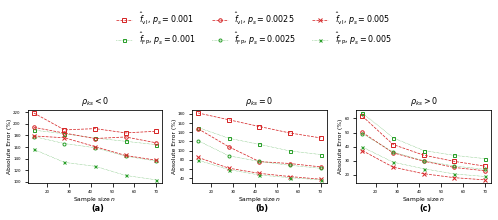

In [9]:
PlotError('athletes_edges.gpickle', 'AbsError_athletes_edges_v2_percent.pdf')

## Simulating the two methods on a Company Dataset

In [ ]:
#Generating the graph from the data
G = nx.read_gpickle("company_edges.gpickle")
A = nx.to_numpy_matrix(G)
A = np.array(A);
G = nx.from_numpy_matrix(A);

In [ ]:
print(r'r_{kk} = ' + str(nx.degree_assortativity_coefficient(G)))
print(r'Number of nodes = ' + str(len(G.nodes())))
print(r'Average Degree = ' + str(np.mean(list(dict(G.degree()).values()))))

nx.draw(G, node_size = 1)

In [ ]:
SaveError(G, 'company_edges.gpickle')

company_edges.gpickle$r_{kk}$ = -0.0134834281077109
p_share = 0.001
p_ks (specified)= -0.2
p_ks (actual)= -0.02008732997486261
$\bar{f} = $0.0010628498547438532

company_edges.gpickle$r_{kk}$ = -0.0134834281077109
p_share = 0.0025
p_ks (specified)= -0.2
p_ks (actual)= -0.03324063813348305
$\bar{f} = $0.0029051229362998653

company_edges.gpickle$r_{kk}$ = -0.0134834281077109
p_share = 0.005
p_ks (specified)= -0.2
p_ks (actual)= -0.045012522351669644
$\bar{f} = $0.005314249273719266

company_edges.gpickle$r_{kk}$ = -0.0134834281077109
p_share = 0.001
p_ks (specified)= 0
p_ks (actual)= 0.012413044010913171
$\bar{f} = $0.012470771628994544

company_edges.gpickle$r_{kk}$ = -0.0134834281077109
p_share = 0.0025
p_ks (specified)= 0
p_ks (actual)= -0.006262603512868987
$\bar{f} = $0.012541628285977468

company_edges.gpickle$r_{kk}$ = -0.0134834281077109
p_share = 0.005
p_ks (specified)= 0
p_ks (actual)= 2.175022533259663e-06
$\bar{f} = $0.03805002479982995

company_edges.gpickle$r_{kk}$ = -0.01

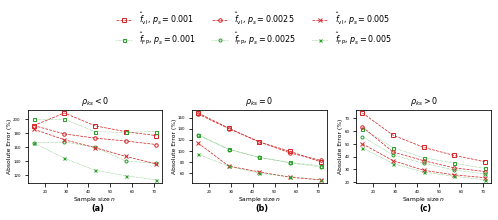

In [10]:
PlotError('company_edges.gpickle', 'AbsError_company_edges_v2_percent.pdf')

# Tracking the Exposure to an Evolving Diffusion (i.e., Time Varying $\bar{f}$)

## Independent Cascade Model on synthetically generated power-law graphs 

In [ ]:
# Generating the results

#Parameters
Terminal_Time = 100 # Number of steps to continue the process
Num_Initial_Nodes = 10 #Number of nodes to start the diffusion process with
Graph_Names = ['A_10k_alpha2pt5_rkk_neg0pt2.npy', 'A_10k_alpha2pt5_rkk_0pt2.npy']

for Infection_Prob in [0.01, 0.05, 0.1]: #Probability of infecting a neighbor
    for Step_Size in [0.005, 0.01, 0.05]: #Step size of the stochastic approximation
        for Ratio in [25, 50, 100]: #For every one step of the diffusion, stochastic approximation takes "Ratio" number of steps

            for j in np.arange(0,len(Graph_Names)):
                A = np.load(Graph_Names[j]) 
                G = nx.from_numpy_matrix(A)

                #Average degree of the graph G = (V,E)
                d = [val for (node, val) in G.degree()]
                bar_d = sum(d)/len(d)

                # Initializing the diffusion at a random set of nodes
                S_Set = []
                s = np.zeros(len(G.nodes))
                num_initial_nodes = 0
                while num_initial_nodes < Num_Initial_Nodes:
                    node_0 = np.random.choice(G.nodes)
                    S_Set.append(node_0)
                    s[node_0] = 1
                    num_initial_nodes+=1

                # Starting the diffusion
                time = 0    
                bar_f_Vec = []
                f_hat_vanilla_Vec = []
                f_hat_FP1_Vec = []
                f_hat_vanilla = 0
                f_hat_FP1 = 0
                rho_ks_Vec = []

                # Diffusion and Tracking under Independent Cascade Model
                while time < Terminal_Time:
                    # The Diffusion according to Independent Cascade Model
                    New_Infections = []
                    for node in S_Set:
                        for neighbor in list(G.neighbors(node)):
                            if (not(neighbor in S_Set)) and (bernoulli.rvs(Infection_Prob) == 1):
                                New_Infections.append(neighbor)
                    if len(New_Infections)>0:
                        S_Set = S_Set + New_Infections
                    for new_infection in New_Infections:
                        s[new_infection] = 1


                    f = [int(v>0) for v in np.matmul(A,s).flatten().tolist()]
                    bar_f = sum(f)/len(f)        

                    # Tracking the exposure using the Two constant step-size stochastic approximation algorithms
                    num_samples = 0
                    while num_samples < Ratio:
                        X_node = np.random.choice(G.nodes)
                        Y_node = np.random.choice(np.array(list(G.edges(data=False))).flatten())

                        f_hat_vanilla = f_hat_vanilla + Step_Size * (f[X_node] - f_hat_vanilla)
                        if f_hat_vanilla > 1:
                            f_hat_vanilla = 1
                        if f_hat_vanilla < 0:
                            f_hat_vanilla = 0

                        f_hat_FP1 = f_hat_FP1 + Step_Size * ((bar_d * f[Y_node]/G.degree(Y_node)) - f_hat_FP1)
                        if f_hat_FP1 > 1:
                            f_hat_FP1 = 1
                        if f_hat_FP1 < 0:
                            f_hat_FP1 = 0                    
                        
                        num_samples+=1

                    rho_ks = np.corrcoef(d, s)[0,1]
                    # Appending the new results
                    bar_f_Vec.append(bar_f)                     
                    f_hat_vanilla_Vec.append(f_hat_vanilla)             
                    f_hat_FP1_Vec.append(f_hat_FP1)
                    rho_ks_Vec.append(rho_ks)

                    time += 1

                    print('Infection_Prob = ' + str(Infection_Prob))      
                    print('Step_Size = ' + str(Step_Size))        
                    print('Ratio = ' + str(Ratio))                            
                    print('Graph = ' + Graph_Names[j])            
                    print('Time = ' + str(time))
                    print('rho_ks = ' + str(rho_ks))            
                    print('bar_f = ' + str(bar_f))
                    print('f_hat_vanilla = ' + str(f_hat_vanilla))        
                    print('f_hat_FP1 = ' + str(f_hat_FP1))
                    print('')
                                        
                    
                Tuple_Name = 'Results_Numerical/ICM_' + Graph_Names[j] + '_InfectionProb_' + str(Infection_Prob) + '_StepSize_' + str(Step_Size) + '_Ratio_' + str(Ratio)
                Tuple_Result = (f_hat_vanilla_Vec, f_hat_FP1_Vec, bar_f_Vec, rho_ks_Vec)

                try:
                    import cPickle as pickle
                except ImportError:  
                    import pickle
                with open(Tuple_Name, 'wb') as fp:
                   pickle.dump(Tuple_Result, fp, protocol=pickle.HIGHEST_PROTOCOL)    

In [ ]:
# Loading the results and plotting

Graph_Names = ['A_10k_alpha2pt5_rkk_neg0pt2.npy', 'A_10k_alpha2pt5_rkk_0pt2.npy']

for Infection_Prob in [0.01, 0.05, 0.1]: #Probability of infecting a neighbor
    for Step_Size in [0.005, 0.01, 0.05]: #Step size of the stochastic approximation
        for Ratio in [25, 50, 100]: #For every one step of the diffusion, stochastic approximation takes "Ratio" number of steps


            for j in np.arange(0,len(Graph_Names)):
                Tuple_Name = 'Results_Numerical/ICM_' + Graph_Names[j] + '_InfectionProb_' + str(Infection_Prob) + '_StepSize_' + str(Step_Size) + '_Ratio_' + str(Ratio)
                
                try:
                    import cPickle as pickle
                except ImportError:  
                    import pickle
                with open(Tuple_Name, 'rb') as fp:
                    Tuple_Name = pickle.load(fp)        
                
                # Plotting the results
                MARKERS = ['D','s','o','x']

                fig = matplotlib.pyplot.gcf()
                fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(7.0, 6), gridspec_kw={'height_ratios': [3, 3, 1]})

                matplotlib.rc('xtick', labelsize=4) 
                matplotlib.rc('ytick', labelsize=4) 

                ax[0].plot(Tuple_Name[0],                                      
                          label = r'$\hat{f}_{\mathrm{vl}}$',
                          color = 'tab:red', 
                          marker = MARKERS[0],
                          markersize = .1,  
                          markerfacecolor = 'none',                          
                          linestyle = ':',
                          linewidth = 0.25                      
                         )

                ax[0].plot(Tuple_Name[1], #For percentage error                       
                          label = r'$\hat{f}_{\mathrm{FP}}$',
                          color = 'tab:green',
                          marker = MARKERS[1],  
                          markersize = 0.2,      
                          markerfacecolor = 'none',                        
                          linestyle = ':' ,                         
                          linewidth = 0.25
                         )           

                ax[0].plot(Tuple_Name[2],                                      
                          label = r'$\bar{f}$',
                          color = 'tab:blue', 
                          marker = MARKERS[2],
                          markersize = .3,  
                          markerfacecolor = 'none',                          
                          linestyle = ':',
                          linewidth = 0.25                      
                         )



                ax[1].plot(np.abs(np.array(Tuple_Name[0])-np.array(Tuple_Name[2])),                                      
                          label = r'$\left|\hat{f}_{\mathrm{vl}}(t) - \bar{f}(t)\right|$',
                          color = 'tab:red', 
                          marker = MARKERS[0],
                          markersize = .1,  
                          markerfacecolor = 'none',                          
                          linestyle = ':',
                          linewidth = 0.25                      
                         )

                ax[1].plot(np.mean(np.abs(np.array(Tuple_Name[0])-np.array(Tuple_Name[2])))*np.ones(len(Tuple_Name[0])),
                          label = r'Average of $\left|\hat{f}_{\mathrm{vl}}(t) - \bar{f}(t)\right|$', 
                          color = 'tab:red',
                          linestyle = '--' ,                         
                          linewidth = 0.75
                         )                                                             

                ax[1].plot(np.abs(np.array(Tuple_Name[1])-np.array(Tuple_Name[2])),
                          label = r'$\left|\hat{f}_{\mathrm{FP}}(t) - \bar{f}(t)\right|$',
                          color = 'tab:green',
                          marker = MARKERS[1],  
                          markersize = 0.2,      
                          markerfacecolor = 'none',                        
                          linestyle = ':' ,                         
                          linewidth = 0.25
                         )     

                ax[1].plot(np.mean(np.abs(np.array(Tuple_Name[1])-np.array(Tuple_Name[2])))*np.ones(len(Tuple_Name[1])),
                          label = r'Average of $\left|\hat{f}_{\mathrm{FP}}(t) - \bar{f}(t)\right|$', 
                          color = 'tab:green',
                          linestyle = '--' ,                         
                          linewidth = 0.75
                         )                  



                ax[2].plot(Tuple_Name[3],                                      
                          label = r'$\rho_{ks}$',
                          color = 'tab:cyan', 
                          marker = MARKERS[2],
                          markersize = 0.2,  
                          markerfacecolor = 'none',                          
                          linestyle = ':',
                          linewidth = 0.25                      
                         )

                ax[0].legend(loc='best', ncol=3, fontsize=10, edgecolor = 'none')     
                ax[1].legend(loc='best', ncol=2, fontsize=10, edgecolor = 'none')     
                ax[2].legend(loc='best', ncol=1, fontsize=10, edgecolor = 'none')   

                ax[0].set_ylabel(r'Estimates of $\bar{f}$', fontsize=12, labelpad=1)
                ax[0].set_xlabel(r'Time Step (t)', fontsize=12, labelpad=1)


                ax[1].set_ylabel(r'Absolute Error', fontsize=12, labelpad=1)
                ax[1].set_xlabel(r'Time Step (t)', fontsize=12, labelpad=1)

                ax[2].set_ylabel(r'$\rho$', fontsize=12, labelpad=1)
                ax[2].set_xlabel(r'Time Step (t)', fontsize=12, labelpad=1)

                for AX in ax.flat:
                    AX.xaxis.set_tick_params(labelsize=10)
                    AX.yaxis.set_tick_params(labelsize=10)    

                plt.subplots_adjust(bottom = 0.08, wspace=0.22, hspace=0.4)    
                plt.savefig('Figures/ICM_' + Graph_Names[j] + '_InfectionProb_' + str(Infection_Prob) + '_StepSize_' + str(Step_Size) + '_Ratio_' + str(Ratio) + '.pdf', bbox_inches='tight')

## Linear Threshold Model on synthetically generated power-law graphs 

In [ ]:
# Generating the results

Terminal_Time = 100 # Number of steps to continue the process
Num_Initial_Nodes = 10 #Number of nodes to start the diffusion process with
Graph_Names = ['A_10k_alpha2pt5_rkk_neg0pt2.npy', 'A_10k_alpha2pt5_rkk_0pt2.npy']

for Threshold in [0.05, 0.15, 0.25]: # Threshold value of the Linear Threshold Model (LTM)
    for Step_Size in [0.005, 0.01, 0.05]: #Step size of the stochastic approximation
        for Ratio in [25, 50, 100]: #For every one step of the diffusion, stochastic approximation takes "Ratio" number of steps

            for j in np.arange(0,len(Graph_Names)):
                A = np.load(Graph_Names[j]) 
                G = nx.from_numpy_matrix(A)
                V = list(G.nodes)


                #Average degree of the graph G = (V,E)
                d = [val for (node, val) in G.degree()]
                bar_d = sum(d)/len(d)
                Thresholds_vec = np.ones(len(d)) * Threshold

                # Initializing the diffusion at a random set of nodes
                S_Set = []
                s = np.zeros(len(G.nodes))
                num_initial_nodes = 0
                while num_initial_nodes < Num_Initial_Nodes:
                    node_0 = np.random.choice(G.nodes)
                    S_Set.append(node_0)
                    s[node_0] = 1
                    num_initial_nodes+=1

                # Starting the diffusion
                time = 0    
                bar_f_Vec = []
                f_hat_vanilla_Vec = []
                f_hat_FP1_Vec = []
                f_hat_vanilla = 0
                f_hat_FP1 = 0
                rho_ks_Vec = []

                # Diffusion and Tracking under Linear Threshold Model
                while time < Terminal_Time:
                    # The Diffusion according to Linear Threshold Model
                    New_Infections = []
                    for node in G.nodes:
                        if (np.sum(s[list(G.neighbors(node))])/d[node]) >= Thresholds_vec[node]:
                            New_Infections.append(node)                  
                    if len(New_Infections)>0:
                        S_Set = S_Set + New_Infections
                    for new_infection in New_Infections:
                        s[new_infection] = 1                   


                    f = [int(v>0) for v in np.matmul(A,s).flatten().tolist()]
                    bar_f = sum(f)/len(f)        

                    # Tracking the exposure using the Two constant step-size stochastic approximation algorithms
                    num_samples = 0
                    while num_samples < Ratio:
                        X_node = np.random.choice(G.nodes)
                        Y_node = np.random.choice(np.array(list(G.edges(data=False))).flatten())

                        f_hat_vanilla = f_hat_vanilla + Step_Size * (f[X_node] - f_hat_vanilla)
                        if f_hat_vanilla > 1:
                            f_hat_vanilla = 1
                        if f_hat_vanilla < 0:
                            f_hat_vanilla = 0

                        f_hat_FP1 = f_hat_FP1 + Step_Size * ((bar_d * f[Y_node]/G.degree(Y_node)) - f_hat_FP1)
                        if f_hat_FP1 > 1:
                            f_hat_FP1 = 1
                        if f_hat_FP1 < 0:
                            f_hat_FP1 = 0                    

                        num_samples+=1

                    rho_ks = np.corrcoef(d, s)[0,1]
                    # Appending the new results
                    bar_f_Vec.append(bar_f)                     
                    f_hat_vanilla_Vec.append(f_hat_vanilla)             
                    f_hat_FP1_Vec.append(f_hat_FP1)
                    rho_ks_Vec.append(rho_ks)

                    time += 1

                    print('Threshold = ' + str(Threshold))     
                    print('Step_Size = ' + str(Step_Size))        
                    print('Ratio = ' + str(Ratio))                            
                    print('Graph = ' + Graph_Names[j])            
                    print('Time = ' + str(time))
                    print('rho_ks = ' + str(rho_ks))            
                    print('bar_f = ' + str(bar_f))
                    print('f_hat_vanilla = ' + str(f_hat_vanilla))        
                    print('f_hat_FP1 = ' + str(f_hat_FP1))
                    print('')

                    
                Tuple_Name = 'Results_Numerical/LTM_' + Graph_Names[j] + '_Threshold_' + str(Threshold) + '_StepSize_' + str(Step_Size) + '_Ratio_' + str(Ratio)
                Tuple_Result = (f_hat_vanilla_Vec, f_hat_FP1_Vec, bar_f_Vec, rho_ks_Vec)

                try:
                    import cPickle as pickle
                except ImportError:  
                    import pickle
                with open(Tuple_Name, 'wb') as fp:
                   pickle.dump(Tuple_Result, fp, protocol=pickle.HIGHEST_PROTOCOL)    
                    

In [ ]:
# Loading the results and plotting

Graph_Names = ['A_10k_alpha2pt5_rkk_neg0pt2.npy', 'A_10k_alpha2pt5_rkk_0pt2.npy']

for Threshold in [0.05, 0.15, 0.25]: # Threshold value of the Linear Threshold Model (LTM)
    for Step_Size in [0.005, 0.01, 0.05]: #Step size of the stochastic approximation
        for Ratio in [25, 50, 100]: #For every one step of the diffusion, stochastic approximation takes "Ratio" number of steps

            for j in np.arange(0,len(Graph_Names)):
                Tuple_Name = 'Results_Numerical/LTM_' + Graph_Names[j] + '_Threshold_' + str(Threshold) + '_StepSize_' + str(Step_Size) + '_Ratio_' + str(Ratio)
                
                try:
                    import cPickle as pickle
                except ImportError:  
                    import pickle
                with open(Tuple_Name, 'rb') as fp:
                    Tuple_Name = pickle.load(fp)        
                
                # Plotting the results
                MARKERS = ['D','s','o','x']

                fig = matplotlib.pyplot.gcf()
                fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(7.0, 6), gridspec_kw={'height_ratios': [3, 3, 1]})

                matplotlib.rc('xtick', labelsize=4) 
                matplotlib.rc('ytick', labelsize=4) 

                ax[0].plot(Tuple_Name[0],                                      
                          label = r'$\hat{f}_{\mathrm{vl}}$',
                          color = 'tab:red', 
                          marker = MARKERS[0],
                          markersize = .1,  
                          markerfacecolor = 'none',                          
                          linestyle = ':',
                          linewidth = 0.25                      
                         )

                ax[0].plot(Tuple_Name[1], #For percentage error                       
                          label = r'$\hat{f}_{\mathrm{FP}}$',
                          color = 'tab:green',
                          marker = MARKERS[1],  
                          markersize = 0.2,      
                          markerfacecolor = 'none',                        
                          linestyle = ':' ,                         
                          linewidth = 0.25
                         )           

                ax[0].plot(Tuple_Name[2],                                      
                          label = r'$\bar{f}$',
                          color = 'tab:blue', 
                          marker = MARKERS[2],
                          markersize = .3,  
                          markerfacecolor = 'none',                          
                          linestyle = ':',
                          linewidth = 0.25                      
                         )



                ax[1].plot(np.abs(np.array(Tuple_Name[0])-np.array(Tuple_Name[2])),                                      
                          label = r'$\left|\hat{f}_{\mathrm{vl}}(t) - \bar{f}(t)\right|$',
                          color = 'tab:red', 
                          marker = MARKERS[0],
                          markersize = .1,  
                          markerfacecolor = 'none',                          
                          linestyle = ':',
                          linewidth = 0.25                      
                         )

                ax[1].plot(np.mean(np.abs(np.array(Tuple_Name[0])-np.array(Tuple_Name[2])))*np.ones(len(Tuple_Name[0])),
                          label = r'Average of $\left|\hat{f}_{\mathrm{vl}}(t) - \bar{f}(t)\right|$', 
                          color = 'tab:red',
                          linestyle = '--' ,                         
                          linewidth = 0.75
                         )                                                             

                ax[1].plot(np.abs(np.array(Tuple_Name[1])-np.array(Tuple_Name[2])),
                          label = r'$\left|\hat{f}_{\mathrm{FP}}(t) - \bar{f}(t)\right|$',
                          color = 'tab:green',
                          marker = MARKERS[1],  
                          markersize = 0.2,      
                          markerfacecolor = 'none',                        
                          linestyle = ':' ,                         
                          linewidth = 0.25
                         )     

                ax[1].plot(np.mean(np.abs(np.array(Tuple_Name[1])-np.array(Tuple_Name[2])))*np.ones(len(Tuple_Name[1])),
                          label = r'Average of $\left|\hat{f}_{\mathrm{FP}}(t) - \bar{f}(t)\right|$', 
                          color = 'tab:green',
                          linestyle = '--' ,                         
                          linewidth = 0.75
                         )                  



                ax[2].plot(Tuple_Name[3],                                      
                          label = r'$\rho_{ks}$',
                          color = 'tab:cyan', 
                          marker = MARKERS[2],
                          markersize = 0.2,  
                          markerfacecolor = 'none',                          
                          linestyle = ':',
                          linewidth = 0.25                      
                         )

                ax[0].legend(loc='best', ncol=3, fontsize=10, edgecolor = 'none')     
                ax[1].legend(loc='best', ncol=2, fontsize=10, edgecolor = 'none')     
                ax[2].legend(loc='best', ncol=1, fontsize=10, edgecolor = 'none')   

                ax[0].set_ylabel(r'Estimates of $\bar{f}$', fontsize=12, labelpad=1)
                ax[0].set_xlabel(r'Time Step (t)', fontsize=12, labelpad=1)


                ax[1].set_ylabel(r'Absolute Error', fontsize=12, labelpad=1)
                ax[1].set_xlabel(r'Time Step (t)', fontsize=12, labelpad=1)

                ax[2].set_ylabel(r'$\rho$', fontsize=12, labelpad=1)
                ax[2].set_xlabel(r'Time Step (t)', fontsize=12, labelpad=1)

                for AX in ax.flat:
                    AX.xaxis.set_tick_params(labelsize=10)
                    AX.yaxis.set_tick_params(labelsize=10)    

                plt.subplots_adjust(bottom = 0.08, wspace=0.22, hspace=0.4)    
                plt.savefig('Figures/LTM_' + Graph_Names[j] + '_Threshold_' + str(Threshold) + '_StepSize_' + str(Step_Size) + '_Ratio_' + str(Ratio) + '.pdf', bbox_inches='tight')

# Formatting the final figures (for WWW)

Graph = A_10k_alpha2pt5_rkk_neg0pt2.npy
p_share = 0.005
p_ks (specified)= -0.2
p_ks (actual)= -0.01588142827071363
bar{f} = 0.0038

Graph = A_10k_alpha2pt5_rkk_neg0pt2.npy
p_share = 0.015
p_ks (specified)= -0.2
p_ks (actual)= -0.027452415746611898
bar{f} = 0.0056

Graph = A_10k_alpha2pt5_rkk_neg0pt2.npy
p_share = 0.025
p_ks (specified)= -0.2
p_ks (actual)= -0.036016727086500507
bar{f} = 0.0071

Graph = A_10k_alpha2pt5_rkk_neg0pt2.npy
p_share = 0.005
p_ks (specified)= 0
p_ks (actual)= -0.0026119216255195443
bar{f} = 0.013

Graph = A_10k_alpha2pt5_rkk_neg0pt2.npy
p_share = 0.015
p_ks (specified)= 0
p_ks (actual)= 0.005819796902813517
bar{f} = 0.0437

Graph = A_10k_alpha2pt5_rkk_neg0pt2.npy
p_share = 0.025
p_ks (specified)= 0
p_ks (actual)= 0.00653103720844869
bar{f} = 0.073

Graph = A_10k_alpha2pt5_rkk_neg0pt2.npy
p_share = 0.005
p_ks (specified)= 0.2
p_ks (actual)= 0.20534466076703992
bar{f} = 0.1291

Graph = A_10k_alpha2pt5_rkk_neg0pt2.npy
p_share = 0.015
p_ks (specified)= 0.2
p_ks (ac

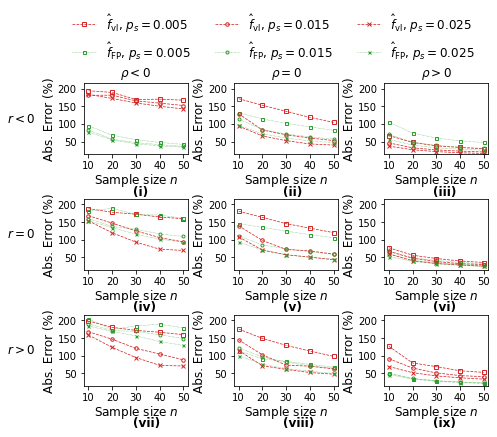

In [10]:
%matplotlib inline
import matplotlib.pylab as pl

Graph_Names = ['A_10k_alpha2pt5_rkk_neg0pt2.npy', 'A_10k_alpha2pt5_rkk_0.npy', 'A_10k_alpha2pt5_rkk_0pt2.npy']
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(7.0, 5))

MARKERS = ['s','o','x']

for j in np.arange(0,len(Graph_Names)):

    n_list = [10, 20, 30, 40, 50]
    
    i=0
    for p_ks_specified in [-0.2, 0, 0.2]:
        k=0
        for p_share in [0.005, 0.015, 0.025]:
            
            Dict_Name = 'Results_Numerical/' + Graph_Names[j] + 'p_ks_specified' + str(p_ks_specified) + 'p_share' + str(p_share)
            try:
                import cPickle as pickle
            except ImportError:  
                import pickle
            with open(Dict_Name, 'rb') as fp:
                Dict_Results = pickle.load(fp)            
            
            (n, bar_f, p_ks, Vanilla_error, FP_error_1, FP_error_2) = zip(*list(Dict_Results.values()))
            ax[j][i].plot(n, Vanilla_error, # For percentage error
#             ax[j][i].plot(n, [i * bar_f[0]/100 for i in Vanilla_error], #For absolute error                          
                          label = r'$\hat{f}_{\mathrm{vl}}$,' + r' $p_s = $' + str(p_share),
                          color = 'tab:red', 
                          marker = MARKERS[k],
                          markersize = 3.5,  
                          markerfacecolor = 'none',                          
                          linestyle = '--',
                          linewidth = 0.75                      
                         )
                          
            ax[j][i].plot(n, FP_error_1, # For percentage error
#             ax[j][i].plot(n, [i * bar_f[0]/100 for i in FP_error_1], #For absolute error                            
                          label = r'$\hat{f}_{\mathrm{FP}}$,' + ' $p_s = $' + str(p_share),
                          color = 'tab:green',
                          marker = MARKERS[k],  
                          markersize = 3,      
                          markerfacecolor = 'none',                        
                          linestyle = ':' ,                         
                          linewidth = 0.5
                         )             
            
            handles, labels = ax[j][i].get_legend_handles_labels()
            
            print('Graph = ' + Graph_Names[j])
            print('p_share = ' + str(p_share))
            print('p_ks (specified)= ' + str(p_ks_specified))                        
            print('p_ks (actual)= ' + str(p_ks[0]))    
            print('bar{f} = ' + str(bar_f[0]))                
            print('')                
            
            k+=1
        i+=1

# Setting the x and y labels    
for AX in ax.flat:
    AX.set_xlabel(r'Sample size $n$', fontsize=12, labelpad=1)
    AX.set_ylabel(r'Abs. Error (%)', fontsize=12, labelpad=2)
    AX.xaxis.set_tick_params(labelsize=10)
    AX.yaxis.set_tick_params(labelsize=10)   
    AX.set_ylim([15, 215])    
    AX.set_xticks([10, 20, 30, 40, 50])  
    AX.set_yticks([50, 100, 150, 200])      
#     AX.tick_params(axis='y', labelpad=0)

# Setting the row and column headers    
cols = [r'$\rho < 0$', r'$\rho = 0$', r'$\rho > 0 $']
rows = [r'$r < 0$', r'$r = 0$', r'$r > 0$']    
pad = 5 
for AX, col in zip(ax[0], cols):
    AX.annotate(col, xy=(0.5, 1.0), xytext=(0, pad+2),
                xycoords='axes fraction', textcoords='offset points',
                size=12, ha='center', va='baseline')

for AX, row in zip(ax[:,0], rows):
    AX.annotate(row, xy=(0, 0.5), xytext=(-AX.yaxis.labelpad - pad, 0),
                xycoords=AX.yaxis.label, textcoords='offset points',
                size=12, ha='right', va='center')
fig.tight_layout()    

# Adding panel numbers
panel_list = ['(i)', '(ii)', '(iii)', '(iv)', '(v)', '(vi)', '(vii)', '(viii)', '(ix)']
panel_list_ind = 0
for AX in ax.flat:
    AX.text(0.47, -0.44, panel_list[panel_list_ind], transform=AX.transAxes, fontsize=12, fontweight='bold', va='top')
    panel_list_ind = panel_list_ind + 1

# Setting the legend and adjusting plots
fig.legend(handles, labels, loc='center', ncol=3, fontsize=12, bbox_to_anchor=(0.55, +1.05), edgecolor = 'none')        
plt.subplots_adjust(bottom = 0.08, wspace=0.44, hspace=0.64)    
plt.savefig('Figures/NEW_AbsError_Alpha2pt5_v2_percent.pdf', bbox_inches='tight')    

Graph = A_10k_alpha2pt2_rkk_neg0pt2.npy
p_share = 0.005
p_ks (specified)= -0.2
p_ks (actual)= -0.013869952164581045
bar{f} = 0.0029

Graph = A_10k_alpha2pt2_rkk_neg0pt2.npy
p_share = 0.015
p_ks (specified)= -0.2
p_ks (actual)= -0.02397540616103468
bar{f} = 0.008

Graph = A_10k_alpha2pt2_rkk_neg0pt2.npy
p_share = 0.025
p_ks (specified)= -0.2
p_ks (actual)= -0.032229858345252556
bar{f} = 0.0115

Graph = A_10k_alpha2pt2_rkk_neg0pt2.npy
p_share = 0.005
p_ks (specified)= 0
p_ks (actual)= 0.005069757490872751
bar{f} = 0.0276

Graph = A_10k_alpha2pt2_rkk_neg0pt2.npy
p_share = 0.015
p_ks (specified)= 0
p_ks (actual)= -0.008522349571558252
bar{f} = 0.0395

Graph = A_10k_alpha2pt2_rkk_neg0pt2.npy
p_share = 0.025
p_ks (specified)= 0
p_ks (actual)= 0.00575316124322013
bar{f} = 0.1064

Graph = A_10k_alpha2pt2_rkk_neg0pt2.npy
p_share = 0.005
p_ks (specified)= 0.2
p_ks (actual)= 0.20108773011973777
bar{f} = 0.23

Graph = A_10k_alpha2pt2_rkk_neg0pt2.npy
p_share = 0.015
p_ks (specified)= 0.2
p_ks (actu

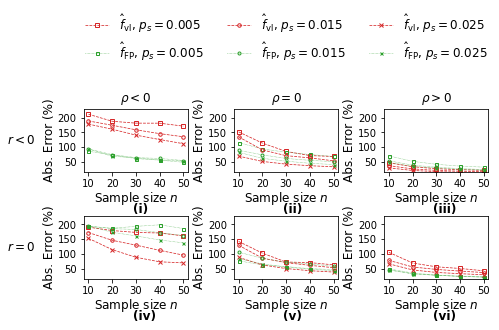

In [5]:

%matplotlib inline
import matplotlib.pylab as pl

Graph_Names = ['A_10k_alpha2pt2_rkk_neg0pt2.npy', 'A_10k_alpha2pt2_rkk_0.npy']
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(7.0, 3.))

MARKERS = ['s','o','x']

for j in np.arange(0,len(Graph_Names)):

    n_list = [10, 20, 30, 40, 50]
    
    i=0
    for p_ks_specified in [-0.2, 0, 0.2]:
        k=0
        for p_share in [0.005, 0.015, 0.025]:
            
            Dict_Name = 'Results_Numerical/' + Graph_Names[j] + 'p_ks_specified' + str(p_ks_specified) + 'p_share' + str(p_share)
            try:
                import cPickle as pickle
            except ImportError:  
                import pickle
            with open(Dict_Name, 'rb') as fp:
                Dict_Results = pickle.load(fp)            
            
            (n, bar_f, p_ks, Vanilla_error, FP_error_1, FP_error_2) = zip(*list(Dict_Results.values()))
            ax[j][i].plot(n, Vanilla_error, # For percentage error
#             ax[j][i].plot(n, [i * bar_f[0]/100 for i in Vanilla_error], #For absolute error                          
                          label = r'$\hat{f}_{\mathrm{vl}}$,' + r' $p_s = $' + str(p_share),
                          color = 'tab:red', 
                          marker = MARKERS[k],
                          markersize = 3.5,  
                          markerfacecolor = 'none',                          
                          linestyle = '--',
                          linewidth = 0.75                      
                         )
                          
            ax[j][i].plot(n, FP_error_1, # For percentage error
#             ax[j][i].plot(n, [i * bar_f[0]/100 for i in FP_error_1], #For absolute error                            
                          label = r'$\hat{f}_{\mathrm{FP}}$,' + ' $p_s = $' + str(p_share),
                          color = 'tab:green',
                          marker = MARKERS[k],  
                          markersize = 3,      
                          markerfacecolor = 'none',                        
                          linestyle = ':' ,                         
                          linewidth = 0.5
                         )             
            
            handles, labels = ax[j][i].get_legend_handles_labels()
            
            print('Graph = ' + Graph_Names[j])
            print('p_share = ' + str(p_share))
            print('p_ks (specified)= ' + str(p_ks_specified))                        
            print('p_ks (actual)= ' + str(p_ks[0]))    
            print('bar{f} = ' + str(bar_f[0]))                
            print('')                
            
            k+=1
        i+=1

# Setting the x and y labels    
for AX in ax.flat:
    AX.set_xlabel(r'Sample size $n$', fontsize=12, labelpad=1)
    AX.set_ylabel(r'Abs. Error (%)', fontsize=12, labelpad=2)
    AX.xaxis.set_tick_params(labelsize=10)
    AX.yaxis.set_tick_params(labelsize=10)    
    AX.set_ylim([15, 230])    
    AX.set_xticks([10, 20, 30, 40, 50])  
    AX.set_yticks([50, 100, 150, 200])  
#     AX.tick_params(axis='y', labelpad=0)

# Setting the row and column headers    
cols = [r'$\rho < 0$', r'$\rho = 0$', r'$\rho > 0 $']
rows = [r'$r < 0$', r'$r = 0$']    
pad = 5 
for AX, col in zip(ax[0], cols):
    AX.annotate(col, xy=(0.5, 1.0), xytext=(0, pad+2),
                xycoords='axes fraction', textcoords='offset points',
                size=12, ha='center', va='baseline')

for AX, row in zip(ax[:,0], rows):
    AX.annotate(row, xy=(0, 0.5), xytext=(-AX.yaxis.labelpad - pad, 0),
                xycoords=AX.yaxis.label, textcoords='offset points',
                size=12, ha='right', va='center')
fig.tight_layout()    

# Adding panel numbers
panel_list = ['(i)', '(ii)', '(iii)', '(iv)', '(v)', '(vi)']
panel_list_ind = 0
for AX in ax.flat:
    AX.text(0.47, -0.49, panel_list[panel_list_ind], transform=AX.transAxes, fontsize=12, fontweight='bold', va='top')
    panel_list_ind = panel_list_ind + 1

# Setting the legend and adjusting plots
fig.legend(handles, labels, loc='center', ncol=3, fontsize=12, bbox_to_anchor=(0.575, +1.20), edgecolor = 'none')        
plt.subplots_adjust(bottom = 0.08, wspace=0.44, hspace=0.69)   
plt.savefig('Figures/NEW_AbsError_Alpha2pt2_v2_percent.pdf', bbox_inches='tight')    

<Figure size 432x288 with 0 Axes>

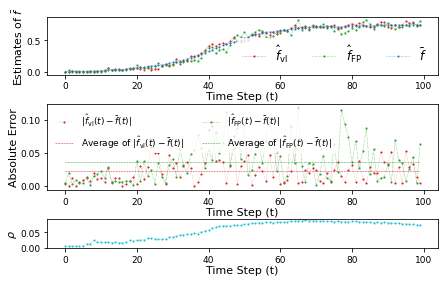

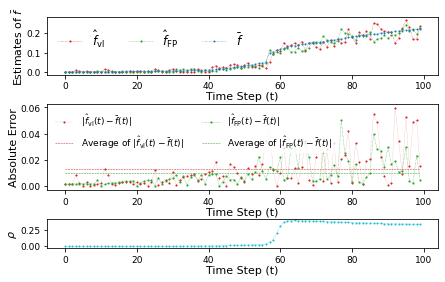

In [6]:

# Loading the results and plotting

Graph_Names = ['A_10k_alpha2pt5_rkk_neg0pt2.npy', 'A_10k_alpha2pt5_rkk_0pt2.npy']

for Infection_Prob in [0.05]: #Probability of infecting a neighbor
    for Step_Size in [0.01]: #Step size of the stochastic approximation
        for Ratio in [100]: #For every one step of the diffusion, stochastic approximation takes "Ratio" number of steps


            for j in np.arange(0,len(Graph_Names)):
                Tuple_Name = 'Results_Numerical/ICM_' + Graph_Names[j] + '_InfectionProb_' + str(Infection_Prob) + '_StepSize_' + str(Step_Size) + '_Ratio_' + str(Ratio)
                
                try:
                    import cPickle as pickle
                except ImportError:  
                    import pickle
                with open(Tuple_Name, 'rb') as fp:
                    Tuple_Name = pickle.load(fp)        
                
                # Plotting the results
                MARKERS = ['D','s','o','x']

                fig = matplotlib.pyplot.gcf()
                fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(7.0, 4.), gridspec_kw={'height_ratios': [2, 3, 1]})

                matplotlib.rc('xtick', labelsize=4) 
                matplotlib.rc('ytick', labelsize=4) 

                ax[0].plot(Tuple_Name[0],                                      
                          label = r'$\hat{f}_{\mathrm{vl}}$',
                          color = 'tab:red', 
                          marker = MARKERS[0],
                          markersize = 1,  
                          markerfacecolor = 'none',                          
                          linestyle = ':',
                          linewidth = 0.5                      
                         )

                ax[0].plot(Tuple_Name[1], #For percentage error                       
                          label = r'$\hat{f}_{\mathrm{FP}}$',
                          color = 'tab:green',
                          marker = MARKERS[1],  
                          markersize = 1,      
                          markerfacecolor = 'none',                        
                          linestyle = ':' ,                         
                          linewidth = 0.5
                         )           

                ax[0].plot(Tuple_Name[2],                                      
                          label = r'$\bar{f}$',
                          color = 'tab:blue', 
                          marker = MARKERS[2],
                          markersize = 1,  
                          markerfacecolor = 'none',                          
                          linestyle = ':',
                          linewidth = 0.5                      
                         )



                ax[1].plot(np.abs(np.array(Tuple_Name[0])-np.array(Tuple_Name[2])),                                      
                          label = r'$\left|\hat{f}_{\mathrm{vl}}(t) - \bar{f}(t)\right|$',
                          color = 'tab:red', 
                          marker = MARKERS[0],
                          markersize = 1,  
                          markerfacecolor = 'none',                          
                          linestyle = ':',
                          linewidth = 0.25                      
                         )

                ax[1].plot(np.mean(np.abs(np.array(Tuple_Name[0])-np.array(Tuple_Name[2])))*np.ones(len(Tuple_Name[0])),
                          label = r'Average of $\left|\hat{f}_{\mathrm{vl}}(t) - \bar{f}(t)\right|$', 
                          color = 'tab:red',
                          linestyle = '--' ,                         
                          linewidth = 0.5
                         )                                                             

                ax[1].plot(np.abs(np.array(Tuple_Name[1])-np.array(Tuple_Name[2])),
                          label = r'$\left|\hat{f}_{\mathrm{FP}}(t) - \bar{f}(t)\right|$',
                          color = 'tab:green',
                          marker = MARKERS[1],  
                          markersize = 1,      
                          markerfacecolor = 'none',                        
                          linestyle = ':' ,                         
                          linewidth = 0.5
                         )     

                ax[1].plot(np.mean(np.abs(np.array(Tuple_Name[1])-np.array(Tuple_Name[2])))*np.ones(len(Tuple_Name[1])),
                          label = r'Average of $\left|\hat{f}_{\mathrm{FP}}(t) - \bar{f}(t)\right|$', 
                          color = 'tab:green',
                          linestyle = '--' ,                         
                          linewidth = 0.5
                         )                  



                ax[2].plot(Tuple_Name[3],                                      
                          label = r'$\rho_{ks}$',
                          color = 'tab:cyan', 
                          marker = MARKERS[2],
                          markersize = 1,  
                          markerfacecolor = 'none',                          
                          linestyle = ':',
                          linewidth = 0.5                      
                         )

                ax[0].legend(loc='best', ncol=3, fontsize=12, edgecolor = 'none')     
                ax[1].legend(loc='best', ncol=2, fontsize=9, edgecolor = 'none')     
#                 ax[2].legend(loc='best', ncol=1, fontsize=10, edgecolor = 'none')   

                ax[0].set_ylabel(r'Estimates of $\bar{f}$', fontsize=11, labelpad=1)
                ax[0].set_xlabel(r'Time Step (t)', fontsize=11, labelpad=1)


                ax[1].set_ylabel(r'Absolute Error', fontsize=11, labelpad=1)
                ax[1].set_xlabel(r'Time Step (t)', fontsize=11, labelpad=1)

                ax[2].set_ylabel(r'$\rho$', fontsize=11, labelpad=1)
                ax[2].set_xlabel(r'Time Step (t)', fontsize=11, labelpad=1)

                for AX in ax.flat:
                    AX.xaxis.set_tick_params(labelsize=9)
                    AX.yaxis.set_tick_params(labelsize=9)    

                plt.subplots_adjust(bottom = 0.08, wspace=0.22, hspace=0.51)    
                plt.savefig('Figures/NEW_ICM_' + Graph_Names[j] + '_InfectionProb_' + str(Infection_Prob) + '_StepSize_' + str(Step_Size) + '_Ratio_' + str(Ratio) + '.pdf', bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

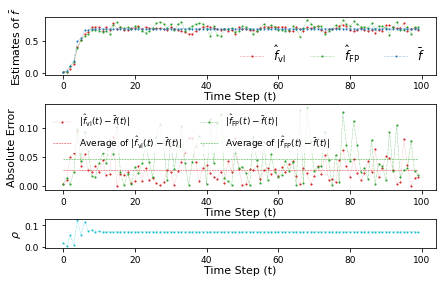

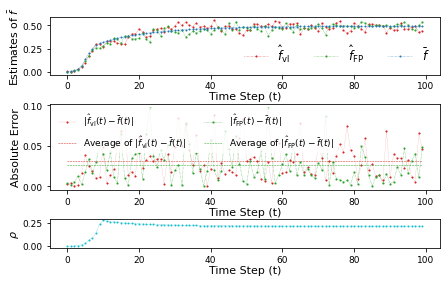

In [7]:

# Loading the results and plotting

Graph_Names = ['A_10k_alpha2pt5_rkk_neg0pt2.npy', 'A_10k_alpha2pt5_rkk_0pt2.npy']

for Threshold in [0.05]: #Probability of infecting a neighbor
    for Step_Size in [0.01]: #Step size of the stochastic approximation
        for Ratio in [100]: #For every one step of the diffusion, stochastic approximation takes "Ratio" number of steps


            for j in np.arange(0,len(Graph_Names)):
                Tuple_Name = 'Results_Numerical/LTM_' + Graph_Names[j] + '_Threshold_' + str(Threshold) + '_StepSize_' + str(Step_Size) + '_Ratio_' + str(Ratio)
                
                try:
                    import cPickle as pickle
                except ImportError:  
                    import pickle
                with open(Tuple_Name, 'rb') as fp:
                    Tuple_Name = pickle.load(fp)        
                
                # Plotting the results
                MARKERS = ['D','s','o','x']

                fig = matplotlib.pyplot.gcf()
                fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(7.0, 4.), gridspec_kw={'height_ratios': [2, 3, 1]})

                matplotlib.rc('xtick', labelsize=4) 
                matplotlib.rc('ytick', labelsize=4) 

                ax[0].plot(Tuple_Name[0],                                      
                          label = r'$\hat{f}_{\mathrm{vl}}$',
                          color = 'tab:red', 
                          marker = MARKERS[0],
                          markersize = 1,  
                          markerfacecolor = 'none',                          
                          linestyle = ':',
                          linewidth = 0.5                      
                         )

                ax[0].plot(Tuple_Name[1], #For percentage error                       
                          label = r'$\hat{f}_{\mathrm{FP}}$',
                          color = 'tab:green',
                          marker = MARKERS[1],  
                          markersize = 1,      
                          markerfacecolor = 'none',                        
                          linestyle = ':' ,                         
                          linewidth = 0.5
                         )           

                ax[0].plot(Tuple_Name[2],                                      
                          label = r'$\bar{f}$',
                          color = 'tab:blue', 
                          marker = MARKERS[2],
                          markersize = 1,  
                          markerfacecolor = 'none',                          
                          linestyle = ':',
                          linewidth = 0.5                      
                         )



                ax[1].plot(np.abs(np.array(Tuple_Name[0])-np.array(Tuple_Name[2])),                                      
                          label = r'$\left|\hat{f}_{\mathrm{vl}}(t) - \bar{f}(t)\right|$',
                          color = 'tab:red', 
                          marker = MARKERS[0],
                          markersize = 1,  
                          markerfacecolor = 'none',                          
                          linestyle = ':',
                          linewidth = 0.25                      
                         )

                ax[1].plot(np.mean(np.abs(np.array(Tuple_Name[0])-np.array(Tuple_Name[2])))*np.ones(len(Tuple_Name[0])),
                          label = r'Average of $\left|\hat{f}_{\mathrm{vl}}(t) - \bar{f}(t)\right|$', 
                          color = 'tab:red',
                          linestyle = '--' ,                         
                          linewidth = 0.5
                         )                                                             

                ax[1].plot(np.abs(np.array(Tuple_Name[1])-np.array(Tuple_Name[2])),
                          label = r'$\left|\hat{f}_{\mathrm{FP}}(t) - \bar{f}(t)\right|$',
                          color = 'tab:green',
                          marker = MARKERS[1],  
                          markersize = 1,      
                          markerfacecolor = 'none',                        
                          linestyle = ':' ,                         
                          linewidth = 0.5
                         )     

                ax[1].plot(np.mean(np.abs(np.array(Tuple_Name[1])-np.array(Tuple_Name[2])))*np.ones(len(Tuple_Name[1])),
                          label = r'Average of $\left|\hat{f}_{\mathrm{FP}}(t) - \bar{f}(t)\right|$', 
                          color = 'tab:green',
                          linestyle = '--' ,                         
                          linewidth = 0.5
                         )                  



                ax[2].plot(Tuple_Name[3],                                      
                          label = r'$\rho_{ks}$',
                          color = 'tab:cyan', 
                          marker = MARKERS[2],
                          markersize = 1,  
                          markerfacecolor = 'none',                          
                          linestyle = ':',
                          linewidth = 0.5                      
                         )

                ax[0].legend(loc='best', ncol=3, fontsize=12, edgecolor = 'none')     
                ax[1].legend(loc='best', ncol=2, fontsize=9, edgecolor = 'none')     
#                 ax[2].legend(loc='best', ncol=1, fontsize=10, edgecolor = 'none')   

                ax[0].set_ylabel(r'Estimates of $\bar{f}$', fontsize=11, labelpad=1)
                ax[0].set_xlabel(r'Time Step (t)', fontsize=11, labelpad=1)


                ax[1].set_ylabel(r'Absolute Error', fontsize=11, labelpad=1)
                ax[1].set_xlabel(r'Time Step (t)', fontsize=11, labelpad=1)

                ax[2].set_ylabel(r'$\rho$', fontsize=11, labelpad=1)
                ax[2].set_xlabel(r'Time Step (t)', fontsize=11, labelpad=1)

                for AX in ax.flat:
                    AX.xaxis.set_tick_params(labelsize=9)
                    AX.yaxis.set_tick_params(labelsize=9)    

                plt.subplots_adjust(bottom = 0.08, wspace=0.22, hspace=0.51)    
                plt.savefig('Figures/NEW_LTM_' + Graph_Names[j] + '_Threshold_' + str(Threshold) + '_StepSize_' + str(Step_Size) + '_Ratio_' + str(Ratio) + '.pdf', bbox_inches='tight')

In [8]:
## Loading the results and plotting
def PlotError_TEMP(GraphName, FigName):
    %matplotlib inline
    import matplotlib.pylab as pl
    
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(7.0, 1.6))

    matplotlib.rc('xtick', labelsize=4) 
    matplotlib.rc('ytick', labelsize=4) 

    MARKERS = ['s','o','x']

#     n_list = [int(np.ceil(x*len(G.nodes()))) for x in [0.001, 0.002, 0.003, 0.004, 0.005]]

    i=0
    for p_ks_specified in [-0.2, 0, 0.2]:
        k=0
        for p_share in [0.001, 0.0025, 0.005]:

            Dict_Name = 'Results_Empirical/' + GraphName + 'p_ks_specified' + str(p_ks_specified) + 'p_share' + str(p_share)
            try:
                import cPickle as pickle
            except ImportError:  
                import pickle
            with open(Dict_Name, 'rb') as fp:
                Dict_Results = pickle.load(fp)            
                
            (n, bar_f, p_ks, Vanilla_error, FP_error_1, FP_error_2) = zip(*list(Dict_Results.values()))
            ax[i].plot(n, Vanilla_error, #For percentage error
#             ax[i].plot(n, [i * bar_f[0]/100 for i in Vanilla_error], #For absolute error                                                      
                          label = r'$\hat{f}_{\mathrm{vl}}$' + r', $p_s = $' + str(p_share),
                          color = 'tab:red', 
                          marker = MARKERS[k],
                          markersize = 3.5,  
                          markerfacecolor = 'none',                          
                          linestyle = '--',
                          linewidth = 0.75                      
                         )

            ax[i].plot(n, FP_error_1, #For percentage error
#             ax[i].plot(n, [i * bar_f[0]/100 for i in FP_error_1], #For absolute error                               
                          label = r'$\hat{f}_{\mathrm{FP}}$' + ', $p_s = $' + str(p_share),
                          color = 'tab:green',
                          marker = MARKERS[k],  
                          markersize = 3,      
                          markerfacecolor = 'none',                        
                          linestyle = ':' ,                         
                          linewidth = 0.5
                         )             

            handles, labels = ax[i].get_legend_handles_labels()

#             print(GraphName + r'$r_{kk}$ = ' + str(nx.degree_assortativity_coefficient(G)))
            print('p_share = ' + str(p_share))
            print('p_ks (specified)= ' + str(p_ks_specified))                        
            print('p_ks (actual)= ' + str(p_ks[0]))    
            print(r'$\bar{f} = $' + str(bar_f[0]))                
            print('')                

            k+=1
        i+=1

    # Setting the x and y labels    
    for AX in ax.flat:
        AX.set_xlabel(r'Sample size $n$', fontsize=12, labelpad=1)
        AX.set_ylabel(r'Abs. Error (%)', fontsize=12, labelpad=1)
        AX.xaxis.set_tick_params(labelsize=10)
        AX.yaxis.set_tick_params(labelsize=10)     
    #     AX.tick_params(axis='y', labelpad=0)

    # Setting the row and column headers    
    cols = [r'$\rho < 0$', r'$\rho = 0$', r'$\rho > 0 $']
    pad = 5 
    for AX, col in zip(ax, cols):
        AX.annotate(col, xy=(0.5, 1.0), xytext=(0, pad+1),
                    xycoords='axes fraction', textcoords='offset points',
                    size=12, ha='center', va='baseline')

    fig.tight_layout()    

    # Adding panel numbers
    panel_list = ['(i)', '(ii)', '(iii)']
    panel_list_ind = 0
    for AX in ax.flat:
        AX.text(0.47, -0.4, panel_list[panel_list_ind], transform=AX.transAxes, fontsize=12, fontweight='bold', va='top')
        panel_list_ind = panel_list_ind + 1

    # Setting the legend and adjusting plots
    fig.legend(handles, labels, loc='center', ncol=3, fontsize=12, bbox_to_anchor=(0.51, +1.17), edgecolor = 'none')        
    plt.subplots_adjust(bottom = 0.08, wspace=0.4, hspace=0.5)    
    plt.savefig('Figures/' + FigName, bbox_inches='tight')

p_share = 0.001
p_ks (specified)= -0.2
p_ks (actual)= -0.019209761141881773
$\bar{f} = $0.0008523332623055614

p_share = 0.0025
p_ks (specified)= -0.2
p_ks (actual)= -0.034328328060734575
$\bar{f} = $0.0026635414447048794

p_share = 0.005
p_ks (specified)= -0.2
p_ks (actual)= -0.0481323056772934
$\bar{f} = $0.005220541231621564

p_share = 0.001
p_ks (specified)= 0
p_ks (actual)= 0.0023299695167328257
$\bar{f} = $0.015821436181546984

p_share = 0.0025
p_ks (specified)= 0
p_ks (actual)= 0.015033228203546984
$\bar{f} = $0.06142126571489452

p_share = 0.005
p_ks (specified)= 0
p_ks (actual)= -0.00200988976103198
$\bar{f} = $0.08017259748561688

p_share = 0.001
p_ks (specified)= 0.2
p_ks (actual)= 0.20537098754164096
$\bar{f} = $0.09407628382697635

p_share = 0.0025
p_ks (specified)= 0.2
p_ks (actual)= 0.20062704342401622
$\bar{f} = $0.1813871723844023

p_share = 0.005
p_ks (specified)= 0.2
p_ks (actual)= 0.2009292190799885
$\bar{f} = $0.2478691668442361

p_share = 0.001
p_ks (specified)= -

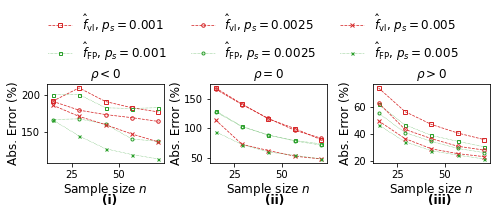

In [9]:
PlotError_TEMP('CA_AstroPh.txt', 'NEW_AbsError_CA_AstroPh_v2_percent.pdf')

PlotError_TEMP('CA_GrQc.txt', 'NEW_AbsError_CA_GrQc_v2_percent.pdf')

PlotError_TEMP('athletes_edges.gpickle', 'NEW_AbsError_athletes_edges_v2_percent.pdf')

PlotError_TEMP('company_edges.gpickle', 'NEW_AbsError_company_edges_v2_percent.pdf')